# Research Abstract Topic Modeling

## Business Overview

The advancement of technology, researchers now have access to hundreds of thousands of research articles across several different fields and topics. While it may be fascinating to an inqusitive mind, the glut of information can be overwhelming. A researcher can be bogged down with the massive amount of information at their finger tips. While papers do have abstracts to help save some time, the sheer number of abstracts to read can still take valuable time away from projects.<br>
<br>
For this poject, I will work with SpaCy and gensim to develop an unsupervised topic model. This model is designed to help researchers parse through the massive amount of articles even faster than reading through just as many abstracts to determine what is worth their valuable time. The model will be able to identify what words define the article's topic. I will also take a look at how to determine how to decide on the optimal number of topics and a way to visualize them.

## Data Understanding

The dataset contains almost 9000 articles containing 6 different topics. In topic modeling, we typically do not know the number of topics in a corpus. Because this is exploratory I wanted to to have some baseline number to compare to the models output. 

The data can be found at: https://www.kaggle.com/blessondensil294/topic-modeling-for-research-articles

In [71]:
#install necessary libraries
# !pip install pyLDAvis -qq
# !pip install -qq -U gensim
# !pip install spacy -qq
# !pip install matplotlib -qq
# !pip install seaborn -qq
# !python -m spacy download en_core_web_md -qq

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import spacy
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()# Visualise inside a notebook
import en_core_web_md
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel

In [73]:
df = pd.read_csv("Data/test.csv")
df.head()

,ID,TITLE,ABSTRACT
0,20973,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...
1,20974,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...
2,20975,Case For Static AMSDU Aggregation in WLANs,Frame aggregation is a mechanism by which mu...
3,20976,The $Gaia$-ESO Survey: the inner disk intermed...,Milky Way open clusters are very diverse in ...
4,20977,Witness-Functions versus Interpretation-Functi...,Proving that a cryptographic protocol is cor...


In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8989 entries, 0 to 8988
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        8989 non-null   int64 
 1   TITLE     8989 non-null   object
 2   ABSTRACT  8989 non-null   object
dtypes: int64(1), object(2)
memory usage: 210.8+ KB


In [75]:
df.columns

Index(['ID', 'TITLE', 'ABSTRACT'], dtype='object')

In [76]:
df["ABSTRACT"].iloc[0]

'  We present novel understandings of the Gamma-Poisson (GaP) model, a\nprobabilistic matrix factorization model for count data. We show that GaP can\nbe rewritten free of the score/activation matrix. This gives us new insights\nabout the estimation of the topic/dictionary matrix by maximum marginal\nlikelihood estimation. In particular, this explains the robustness of this\nestimator to over-specified values of the factorization rank, especially its\nability to automatically prune irrelevant dictionary columns, as empirically\nobserved in previous work. The marginalization of the activation matrix leads\nin turn to a new Monte Carlo Expectation-Maximization algorithm with favorable\nproperties.\n'

### Preprocessing

I will instantiate a pre-trained spaCy model that can be thought as a pipeline to prepare data for modeling. An interesting component of the pipeline is the tagger feature. I will use the tagger feature to remove any unwanted information for analysis. I am using the universal part-of-speech (POS) for the POS tags. They can be found here: https://universaldependencies.org/u/pos/. 

In [77]:
# spaCy model
nlp = en_core_web_md.load()

In [78]:
# tags to remove from text
remove = ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']

In [79]:
# for all abstarcts in the corpus, we convert each word to a token, 
# keep all tokens with letters and remove any stop words and tags we assigned to the remove variable
# then lemmatize and lowercase each token and creates a list of tokens for each abstract.
tokens = [[token.lemma_.lower() for token in abstract if token.pos_ not in remove and not token.is_stop and token.is_alpha] 
          for abstract in nlp.pipe(df["ABSTRACT"])]

In [80]:
#adding on a new column with the list of tokens for each abstract
df["cleaned"] = tokens
df.head()

,ID,TITLE,ABSTRACT,cleaned
0,20973,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...,"[present, novel, understanding, gamma, poisson..."
1,20974,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...,"[meteorites, contain, mineral, solar, system, ..."
2,20975,Case For Static AMSDU Aggregation in WLANs,Frame aggregation is a mechanism by which mu...,"[frame, aggregation, mechanism, multiple, fram..."
3,20976,The $Gaia$-ESO Survey: the inner disk intermed...,Milky Way open clusters are very diverse in ...,"[milky, way, open, cluster, diverse, term, age..."
4,20977,Witness-Functions versus Interpretation-Functi...,Proving that a cryptographic protocol is cor...,"[prove, cryptographic, protocol, correct, secr..."


In [81]:
#comparison bewteen cleaned and uncleaned
df["ABSTRACT"].iloc[0]

'  We present novel understandings of the Gamma-Poisson (GaP) model, a\nprobabilistic matrix factorization model for count data. We show that GaP can\nbe rewritten free of the score/activation matrix. This gives us new insights\nabout the estimation of the topic/dictionary matrix by maximum marginal\nlikelihood estimation. In particular, this explains the robustness of this\nestimator to over-specified values of the factorization rank, especially its\nability to automatically prune irrelevant dictionary columns, as empirically\nobserved in previous work. The marginalization of the activation matrix leads\nin turn to a new Monte Carlo Expectation-Maximization algorithm with favorable\nproperties.\n'

In [82]:
str(df["cleaned"].iloc[0])

"['present', 'novel', 'understanding', 'gamma', 'poisson', 'gap', 'model', 'probabilistic', 'matrix', 'factorization', 'model', 'count', 'datum', 'gap', 'rewrite', 'free', 'score', 'activation', 'matrix', 'give', 'new', 'insight', 'estimation', 'topic', 'dictionary', 'matrix', 'maximum', 'marginal', 'likelihood', 'estimation', 'particular', 'explain', 'robustness', 'estimator', 'specify', 'value', 'factorization', 'rank', 'ability', 'prune', 'irrelevant', 'dictionary', 'column', 'observe', 'previous', 'work', 'marginalization', 'activation', 'matrix', 'lead', 'turn', 'new', 'monte', 'carlo', 'expectation', 'maximization', 'algorithm', 'favorable', 'property']"

In [83]:
#maps all words to the their unique id
dictionary = Dictionary(df["cleaned"])

In [84]:
#how many unqiue words in tokens
print(len(dictionary.token2id))

26176


In [85]:
#takes a look at the first 20 unique words
items = dictionary.token2id.items()
first_twenty = list(items)[:20]
print(first_twenty)

[('ability', 0), ('activation', 1), ('algorithm', 2), ('carlo', 3), ('column', 4), ('count', 5), ('datum', 6), ('dictionary', 7), ('estimation', 8), ('estimator', 9), ('expectation', 10), ('explain', 11), ('factorization', 12), ('favorable', 13), ('free', 14), ('gamma', 15), ('gap', 16), ('give', 17), ('insight', 18), ('irrelevant', 19)]


26,000 tokens is alot of information to process. Therefore, I will condense the number of words by removing words that appear in less than 25 abstracts and appear in no more than 50% of the abstracts and I will keep the top 1000 words.

In [86]:
dictionary.filter_extremes(no_below=10, no_above=0.5, keep_n=1000)

In [87]:
#builds bag of words
corpus = [dictionary.doc2bow(abstract) for abstract in df["cleaned"]]

### Best number of topics?

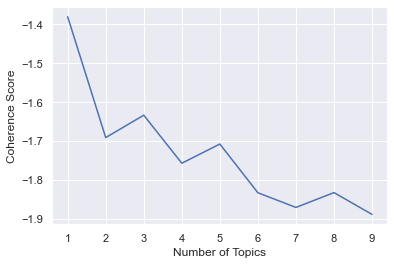

In [88]:
topics = []
score = []
for i in range(1,10,1):
   lda_model = LdaMulticore(corpus=corpus, 
                            id2word=dictionary, 
                            iterations=100, 
                            num_topics=i, 
                            workers = 4, 
                            passes=10, 
                            random_state=42)
   cm = CoherenceModel(model=lda_model, 
                       corpus=corpus, 
                       dictionary=dictionary, 
                       coherence='u_mass')
   topics.append(i)
   score.append(cm.get_coherence())

plt.plot(topics, score)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.show()

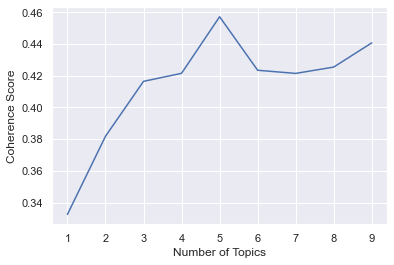

In [89]:
topics = []
score = []
for i in range(1,10,1):
   lda_model = LdaMulticore(corpus=corpus, 
                            id2word=dictionary, 
                            iterations=100, 
                            num_topics=i, 
                            workers = 4, 
                            passes=10, 
                            random_state=42)
   cm = CoherenceModel(model=lda_model, 
                       texts = df["cleaned"], 
                       corpus=corpus, 
                       dictionary=dictionary, 
                       coherence='c_v')
   topics.append(i)
   score.append(cm.get_coherence())
plt.plot(topics, score)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.show()

In [90]:
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=5, workers = 4, passes=10)

In [91]:
lda_model.print_topics(-1)

[(0,
  '0.013*"system" + 0.010*"base" + 0.009*"paper" + 0.008*"result" + 0.008*"object" + 0.008*"datum" + 0.007*"information" + 0.007*"network" + 0.007*"new" + 0.007*"approach"'),
 (1,
  '0.025*"model" + 0.016*"system" + 0.013*"state" + 0.012*"energy" + 0.012*"study" + 0.012*"phase" + 0.010*"quantum" + 0.009*"scale" + 0.009*"dynamic" + 0.008*"interaction"'),
 (2,
  '0.024*"model" + 0.019*"network" + 0.016*"propose" + 0.015*"method" + 0.014*"datum" + 0.014*"algorithm" + 0.011*"approach" + 0.011*"learn" + 0.011*"base" + 0.010*"learning"'),
 (3,
  '0.011*"result" + 0.010*"rate" + 0.009*"model" + 0.009*"method" + 0.009*"field" + 0.008*"problem" + 0.008*"function" + 0.008*"test" + 0.007*"star" + 0.007*"high"'),
 (4,
  '0.013*"result" + 0.013*"space" + 0.012*"function" + 0.011*"graph" + 0.011*"prove" + 0.011*"group" + 0.010*"problem" + 0.009*"equation" + 0.009*"solution" + 0.009*"study"')]

In [92]:
lda_model.top_topics(corpus = corpus, texts = df["ABSTRACT"], dictionary=dictionary, topn= 10)

[([(0.023897175, 'model'),
   (0.018515777, 'network'),
   (0.015608287, 'propose'),
   (0.015485318, 'method'),
   (0.014441251, 'datum'),
   (0.014062619, 'algorithm'),
   (0.011172514, 'approach'),
   (0.011153318, 'learn'),
   (0.010616336, 'base'),
   (0.01030026, 'learning')],
  -1.2360380487398253),
 ([(0.013384228, 'system'),
   (0.009877656, 'base'),
   (0.009155894, 'paper'),
   (0.008260507, 'result'),
   (0.008184012, 'object'),
   (0.008145867, 'datum'),
   (0.0072838264, 'information'),
   (0.0072056716, 'network'),
   (0.007105211, 'new'),
   (0.006651505, 'approach')],
  -1.546066091299426),
 ([(0.012850382, 'result'),
   (0.012710334, 'space'),
   (0.011556221, 'function'),
   (0.011495465, 'graph'),
   (0.010628253, 'prove'),
   (0.010549573, 'group'),
   (0.010306739, 'problem'),
   (0.0094059715, 'equation'),
   (0.009274215, 'solution'),
   (0.009201494, 'study')],
  -1.9331745992045666),
 ([(0.024771938, 'model'),
   (0.015620885, 'system'),
   (0.012863683, 'stat

In [93]:
i= 1000
print(df["ABSTRACT"][i])
lda_model[corpus][i]

  We consider the problem of learning from noisy data in practical settings
where the size of data is too large to store on a single machine. More
challenging, the data coming from the wild may contain malicious outliers. To
address the scalability and robustness issues, we present an online robust
learning (ORL) approach. ORL is simple to implement and has provable robustness
guarantee -- in stark contrast to existing online learning approaches that are
generally fragile to outliers. We specialize the ORL approach for two concrete
cases: online robust principal component analysis and online linear regression.
We demonstrate the efficiency and robustness advantages of ORL through
comprehensive simulations and predicting image tags on a large-scale data set.
We also discuss extension of the ORL to distributed learning and provide
experimental evaluations.



[(2, 0.9867615)]

In [94]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

C:\Users\david\anaconda3\envs\topic-modeling\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [95]:
df['topic'] = [sorted(lda_model[corpus][text])[0][0] for text in range(len(df["ABSTRACT"]))]

In [96]:
df.head(25)

,ID,TITLE,ABSTRACT,cleaned,topic
0,20973,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...,"[present, novel, understanding, gamma, poisson...",2
1,20974,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...,"[meteorites, contain, mineral, solar, system, ...",0
2,20975,Case For Static AMSDU Aggregation in WLANs,Frame aggregation is a mechanism by which mu...,"[frame, aggregation, mechanism, multiple, fram...",0
3,20976,The $Gaia$-ESO Survey: the inner disk intermed...,Milky Way open clusters are very diverse in ...,"[milky, way, open, cluster, diverse, term, age...",0
4,20977,Witness-Functions versus Interpretation-Functi...,Proving that a cryptographic protocol is cor...,"[prove, cryptographic, protocol, correct, secr...",2
5,20978,Pairwise Difference Estimation of High Dimensi...,This paper proposes a regularized pairwise d...,"[paper, propose, regularized, pairwise, differ...",2
6,20979,Dissecting the multivariate extremal index and...,A central issue in the theory of extreme val...,"[central, issue, theory, extreme, value, focus...",1
7,20980,"Big Universe, Big Data: Machine Learning and I...",Astrophysics and cosmology are rich with dat...,"[astrophysics, cosmology, rich, datum, advent,...",0
8,20981,Natural Language Does Not Emerge 'Naturally' i...,A number of recent works have proposed techn...,"[number, recent, work, propose, technique, end...",0
9,20982,Properties and Origin of Galaxy Velocity Bias ...,We use the hydrodynamical galaxy formation s...,"[use, hydrodynamical, galaxy, formation, simul...",1


In [97]:
df.topic.value_counts()

0    3899
1    2121
2    1861
4     762
3     346
Name: topic, dtype: int64